In [1]:
pip install monai

  Obtaining dependency information for monai from https://files.pythonhosted.org/packages/08/94/e8a7ba00dd0c7ce959648b562043bd22125d65f5e519e566c822f71bc437/monai-1.3.0-202310121228-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from glob import glob
import shutil
from tqdm import tqdm

import numpy as np
import nibabel as nib
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm
from monai.transforms import(
    Compose,
    #AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism

"""
This file is for preporcessing only, it contains all the functions that you need
to make your data ready for training.

You need to install the required libraries if you do not already have them.

pip install os, ...
"""
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, EfficientNetBN
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

import torch
#from preporcess import prepare
#from utilities import train

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def prepare(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128,128,128], cache=False):

    """
    This function is for preprocessing, it contains only the basic transforms, but you can add more operations that you 
    find in the Monai documentation.
    https://monai.io/docs.html
    """

    set_determinism(seed=0)
    
    #print(os.path.join(in_dir, "train_image", "*.nii"))
    path_train_volumes = sorted(glob.glob(os.path.join(in_dir, "train_image", "*.nii")))
    path_train_segmentation = sorted(glob.glob(os.path.join(in_dir, "train_mask", "*.nii")))

    path_test_volumes = sorted(glob.glob(os.path.join(in_dir, "test_image", "*.nii")))
    path_test_segmentation = sorted(glob.glob(os.path.join(in_dir, "test_mask", "*.nii")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            #AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            #AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),

            
        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=8)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=8)

        return train_loader, test_loader


In [4]:
def prepare(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[448,448,128], cache=False):

    """
    This function is for preprocessing, it contains only the basic transforms, but you can add more operations that you 
    find in the Monai documentation.
    https://monai.io/docs.html
    """

    set_determinism(seed=0)
    
    #print(os.path.join(in_dir, "train_image", "*.nii"))
    path_train_volumes = sorted(glob.glob(os.path.join(in_dir, "train_image", "*.nii")))
    path_train_segmentation = sorted(glob.glob(os.path.join(in_dir, "train_mask", "*.nii")))

    path_test_volumes = sorted(glob.glob(os.path.join(in_dir, "test_image", "*.nii")))
    path_test_segmentation = sorted(glob.glob(os.path.join(in_dir, "test_mask", "*.nii")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstd(keys=["vol", "seg"]),  # Ensure channel first
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            
            RandCropByPosNegLabeld(
                keys=["vol", "seg"],
                label_key="seg",
                spatial_size=(128,128, 32),
                num_samples=44,
                image_key="vol",
                image_threshold=0,
            ),
            
            ToTensord(keys=["vol", "seg"]),
        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstd(keys=["vol", "seg"]),  # Ensure channel first
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),
        ]
    )


    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=4)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=2)

        return train_loader, test_loader


In [5]:
def show_patient(data, SLICE_NUMBER=1, train=True, test=False):
    """
    This function is to show one patient from your datasets, so that you can si if the it is okay or you need 
    to change/delete something.
    `data`: this parameter should take the patients from the data loader, which means you need to can the function
    prepare first and apply the transforms that you want after that pass it to this function so that you visualize 
    the patient with the transforms that you want.
    `SLICE_NUMBER`: this parameter will take the slice number that you want to display/show
    `train`: this parameter is to say that you want to display a patient from the training data (by default it is true)
    `test`: this parameter is to say that you want to display a patient from the testing patients.
    """

    check_patient_train, check_patient_test = data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)
    
    print(view_train_patient[0]["vol"].shape)
    
    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient[0]["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient[0]["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient[0]["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient[0]["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()


In [6]:
data_dir = '/kaggle/input/cerebrovascular-segmentation/thesisnewdataset'
model_dir = '/kaggle/working/' 
#data_in = prepare(data_dir, cache=True)
data_in = prepare(data_dir)

/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


torch.Size([4, 1, 128, 128, 32])


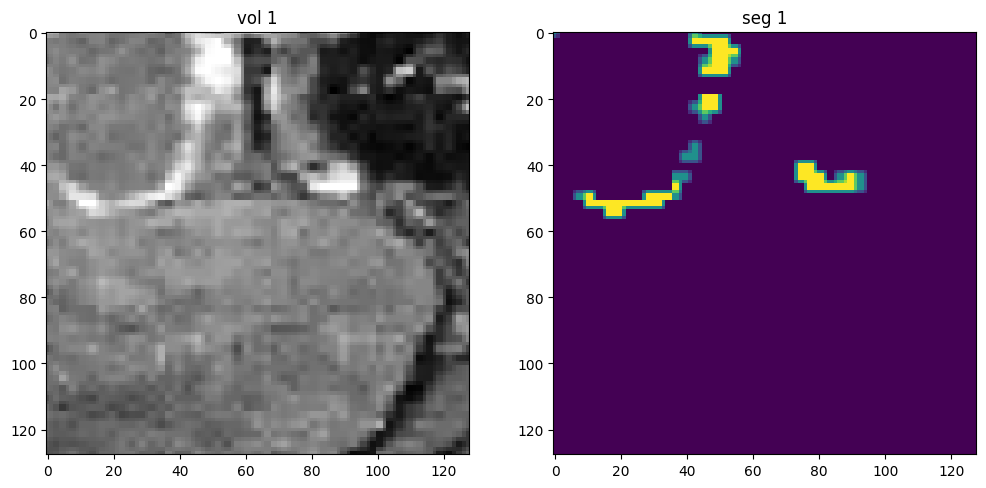

In [7]:
show_patient(data_in)

In [8]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

import torch
#from preporcess import prepare
#from utilities import train
device = torch.device("cuda:0")
model = UNet(
    3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256, 512), 
    strides=(2, 2, 2,2,2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [9]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm

In [10]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it 
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights` 
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

In [11]:
def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1 , device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:
            
            train_step += 1
            
            volume = batch_data[0]["vol"]
            label = batch_data[0]["seg"]
            label = label != 0
#             print(volume.shape)
#             print(label.shape)
            
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)
            
            train_loss = loss(outputs, label)
            
            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(train_loader) // 1}, "
                f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)
        
        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:

            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:

                    test_step += 1
                    
                    test_volume = test_data["vol"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)
#                     print(test_volume.shape)
#                     print(test_label.shape)
                    test_outputs = model(test_volume)
                    
                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    
                
                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))
                
                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")



In [12]:
def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1 , device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:
            
            train_step += 1
            train_batch_loss = 0
            batch_metric_train = 0
            for i in range(len(batch_data)):
                volume = batch_data[i]["vol"]
                label = batch_data[i]["seg"]
                label = label != 0
#             print(volume.shape)
#             print(label.shape)
            
                volume, label = (volume.to(device), label.to(device))

                optim.zero_grad()
                outputs = model(volume)
            
                train_loss = loss(outputs, label)
            
                train_loss.backward()
                optim.step()

                train_batch_loss += train_loss.item()
#                 print(
#                 f"{i} / {train_step}/{len(train_loader) // 1}, "
#                 f"Train_loss: {train_loss.item():.4f}")

                train_metric = dice_metric(outputs, label)
                batch_metric_train += train_metric
                #print(f'Train_patch_dice: {train_metric:.4f}')
            
            
            train_epoch_loss += train_batch_loss / len(batch_data)
            
            print(
                f"{train_step}/{len(train_loader) // 1}, "
                f"Train_loss: {train_batch_loss / len(batch_data):.4f}")

            
            epoch_metric_train += batch_metric_train / len(batch_data)
            print(f'Train_batch_dice: {batch_metric_train / len(batch_data):.4f}')
                
                
                
                
                

        print('-'*20)
        
        train_epoch_loss /= train_step
        print(f'Total_Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Total_Epoch_dice_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:

            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:

                    test_step += 1
                    
                    test_volume = test_data["vol"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)
#                     print(test_volume.shape)
#                     print(test_label.shape)
                    test_outputs = model(test_volume)
                    
                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    
                
                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))
                
                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")



In [13]:
#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

if __name__ == '__main__':
    train(model, data_in, loss_function, optimizer, 10, model_dir)

----------
epoch 1/10
1/9, Train_loss: 0.5269
Train_batch_dice: 0.4731
2/9, Train_loss: 0.5215
Train_batch_dice: 0.4785
3/9, Train_loss: 0.5203
Train_batch_dice: 0.4797
4/9, Train_loss: 0.5122
Train_batch_dice: 0.4878
5/9, Train_loss: 0.5143
Train_batch_dice: 0.4857
6/9, Train_loss: 0.5124
Train_batch_dice: 0.4876
7/9, Train_loss: 0.5100
Train_batch_dice: 0.4900
8/9, Train_loss: 0.5108
Train_batch_dice: 0.4892
9/9, Train_loss: 0.5070
Train_batch_dice: 0.4930
--------------------
Total_Epoch_loss: 0.5151
Total_Epoch_dice_metric: 0.4849
test_loss_epoch: 0.5191
test_dice_epoch: 0.4809
current epoch: 1 current mean dice: 0.4805
best mean dice: 0.4809 at epoch: 1
----------
epoch 2/10
1/9, Train_loss: 0.5094
Train_batch_dice: 0.4906
2/9, Train_loss: 0.5056
Train_batch_dice: 0.4944
3/9, Train_loss: 0.5052
Train_batch_dice: 0.4948
4/9, Train_loss: 0.5039
Train_batch_dice: 0.4961
5/9, Train_loss: 0.4990
Train_batch_dice: 0.5010
6/9, Train_loss: 0.4997
Train_batch_dice: 0.5003
7/9, Train_loss: 

In [14]:
#there is a confusion. i have trained my model with 128,128,32 and test with 448,448,128. may be this is wrong. check this out